### NECSESSARY IMPORTS

In [43]:
from matplotlib.patches import Rectangle

import random
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
from sklearn.manifold import TSNE,MDS,Isomap
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
import pandas as pd



def _set_seeds(seed):


    """ sets all the required seed values for a run"""
        

    random.seed(seed)
    np.random.seed(seed) 
    os.environ['PYTHONHASHSEED'] = str(seed)
    try:
        import tensorflow as tf
        tf.random.set_seed(seed)
    except Exception as e:
        pass    
    try:
        import torch
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.use_deterministic_algorithms(True)
        torch.manual_seed(seed)
    except Exception as e:
        pass
    
# select the random seed for generating the dataset
random_seed=40
#-------------------------------------------------

_set_seeds(random_seed) 

### FUNCTION FOR CREATING NOVELTY-TYPE 3

In [44]:
import math
# function for creating the Novelty-type 3(which forms a semicricle)
def novelty3(r, h, k,semi_len):
    x0 = 1+h - r  # determine x start
    x1 = h + r-1  # determine x finish
    x = np.linspace(x0, x1, semi_len)  # many points to solve for y

    # use numpy for array solving of the semicircle equation
    y = k + np.sqrt(r**2 - (x - h)**2)  
    return x, y

#x, y = novelty3(3, 0, 11,22)  # function call
#plt.scatter(x, y, s=3, c='turquoise')  # plot
#plt.gca().set_aspect('equal', adjustable='box')  # set the plot aspect to be equal



### DEFINING THE FUNCTION FOR GENERATING THE  DATASET


In [45]:
from random import uniform,randint,choice

name='GAD'


def gen_coords(person,nationality,gender,x1, y1, n,anomalous,pairs,traj_pair_details):
    total_timestamps=n
    x,y,details=[x1],[y1],[]
    x_point,y_point=x1,y1
    x.append(x1)
    y.append(y1)
    timestep=0
    ts,te=random.choice(pairs)
    #print(person)
    #print('randomly selected:',ts,te,anomalous)
    traj_pair_details[person]=[ts,te]
    
    
    rand_list=list(range(ts,te+1))
    
    while(timestep<=total_timestamps):
        if anomalous==3: #unknown normal group
            GAD_label=0
            if timestep<total_timestamps//4:
                x_rand=randint(1,3)
                y_rand=randint(-10,0)
                
            
            elif total_timestamps//4<timestep<=total_timestamps//2:
                x_rand=randint(1,3)
                y_rand=randint(0,10)
            elif total_timestamps//2<timestep<=2*total_timestamps//3:
                x_rand=randint(1,3)
                y_rand=randint(-10,0)
            else:
                x_rand=randint(1,3)
                y_rand=randint(0,10)
            
        elif ts<=timestep<=te and anomalous==1:  # actual anomalous group subset
                #print('lllmmmml')
                GAD_label=1
                x_rand=0
                y_rand=2
        
        else:               # normal  group  subset
            if anomalous==1:
                GAD_label=1
            else:
                GAD_label=0
            x_rand=randint(1,3)
            y_rand=randint(-6,8)
            while y_rand==0:
                    y_rand=randint(-6,8)
                
        if timestep==ts and anomalous==2:     # unknown anomalous group part
            GAD_label=1
            semi_x, semi_y = novelty3(50,x_point+50, y_point,len(rand_list))  # function call for novelty3 generation
            x.extend(semi_x)
            y.extend(semi_y)
            
            for i,j in zip(semi_x, semi_y ):
                plt.plot(i,j, 'r-',marker='o')
                
                details.append([timestep,person,nationality,gender,i,j, GAD_label])
            
            x_point=semi_x[-1]-1
            y_point=semi_y[-1]-1
            
            timestep=rand_list[-1]+1
            
            continue
        
        
        prev_x=x_rand
        prev_y=y_rand
        
        point1=x_point+x_rand
        point2=y_point+y_rand    
        x.append(point1)
        y.append(point2)    
        details.append([timestep,person,nationality,gender,point1,point2, GAD_label])
        x_point=x_point+x_rand
        y_point=y_point+y_rand

        timestep+=1
        
    
    if anomalous in [1,2]:
        
        plt.plot(x,y, 'r-',marker='o')
        #plt.show()
    else:
        plt.plot(x,y, 'xb-',marker='o')
    
    return x,y,details,traj_pair_details



### SELECT THE DATASET NUMBER FOR CREATION

In [50]:

### Choose the total time (sequence) steps 
steps=100


# dataset_dict= {dataset_number:[total_trajectories,random_pairs_of_contionus_anomalies,anom_trajectories]}
dataset_dict={
            9:[150,[[3,23],[21,44],[46,59],[69,87]],  # Novelty dataset
                 [6,56,67,8,80,93,112,76,82,74,34,4,99,101,110,149,144,139],steps] ,
            10:[6,[[8,30],[30,50],[50,80],[20,40]],             #anomalous sample data
                 [1,3,2],steps],
            11:[15,[[8,30],[30,50],[50,80],[20,40]],             #anomalous sample data
                 [1,3,5,9],steps]
             }

###choose 'dataset number'  as the key of the dictionary 'dataset_dict' , 
dataset_number=10

### Choose the novelty level 
novelty_level=0.05 # among  0,0.01, 0.05,0.1 

### PLOTTING THE SELECTED DATASET

<ipython-input-45-0b54814b4100>:93: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "xb-" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(x,y, 'xb-',marker='o')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


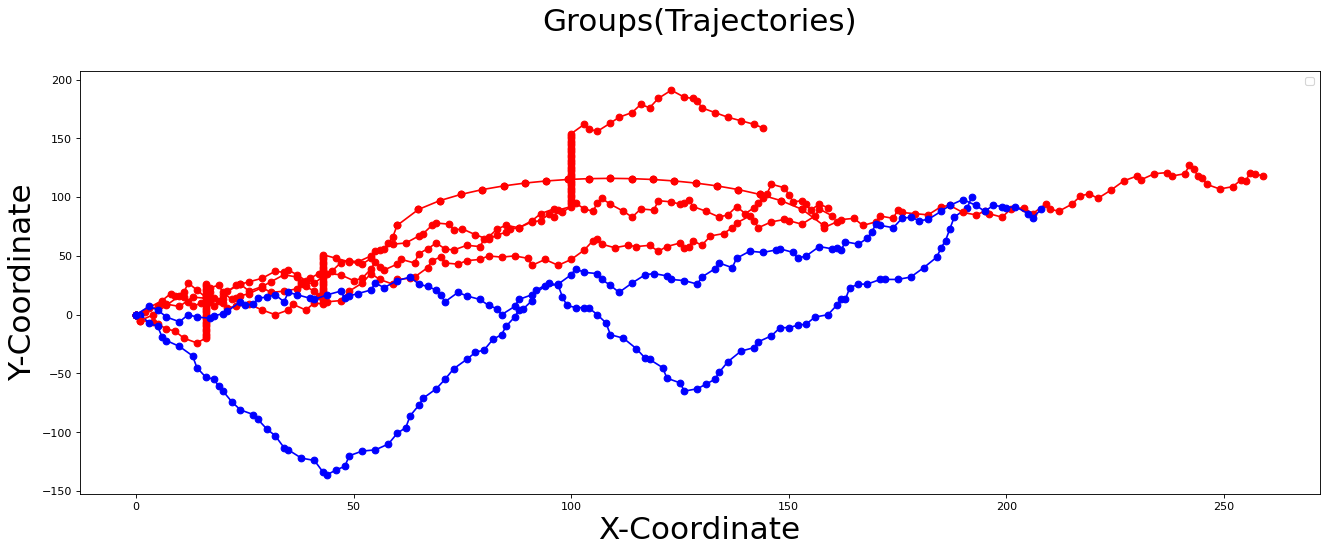

<Figure size 1440x2880 with 0 Axes>

In [51]:

trajectories=dataset_dict[dataset_number][0]


plt.figure(figsize=(20, 7), dpi=80)
init_x=0
init_y=0



max_x=0
max_y=0
data=[]

pairs=dataset_dict[dataset_number][1]
anom_trajectories=dataset_dict[dataset_number][2]
#print(list(range(1,trajectories+1)))
remaining_trajectories1=[x for x in list(range(1,trajectories+1)) if x not in anom_trajectories] # possible trajectories for unknown anomlous novelty

other_anom_novelty_trajectories=random.sample(remaining_trajectories1,ceil(trajectories*novelty_level/2))

remaining_trajectories2=[x for x in remaining_trajectories1 if x not in other_anom_novelty_trajectories]


other_norm_novelty_trajectories=random.sample(remaining_trajectories1,ceil(trajectories*novelty_level/2))


if len(anom_trajectories)==0:
    dataset_type='norm'
else:
    dataset_type='anom'

    
    
traj_pair_details={}


for p in range(1,trajectories+1):
    #anomalous=False
    if p in anom_trajectories: 
        anomalous=1
    elif p in other_norm_novelty_trajectories: 
        
        anomalous=3
    elif p in other_anom_novelty_trajectories:
        anomalous=2
      
    
    else:
        anomalous=0
    
    
    gender=choice(['male','female'])
    nationality=choice(['Indian','German','American','African','Chinese'])
    
    x,y,details,traj_pair_details=gen_coords(p,nationality,gender,init_x,init_y,steps-1,anomalous,pairs,
    traj_pair_details)
    
    init_x+=0
    init_y+=0
    data.append(details)
    
    if max(x)>max_x:
        #print(x)
        max_x=max(x)
    if max(y)>max_y:
        #print(y)
        #print(max(y))
        max_y=max(y)


plt.xlabel('X-Coordinate',fontsize=28)
plt.ylabel('Y-Coordinate',fontsize=28)
plt.legend()
plt.title('Groups(Trajectories)\n',fontsize=28)
plt.figure(figsize=(20,40))
plt.show()
new_data=sorted([list(j)  for i in np.reshape(a=np.array(data) ,newshape=(1,trajectories*(steps),len(details[0]))) for j in i],key=lambda x: int(x[0]))







## SAVE DATASET AS .CSV


In [52]:
import csv 

heads = ['Timestep','Person', 'Nationality', 'Gender','X_Coord','Y_Coord','Target'] 
#filename = "Trajectorys_30_50_10p_100t_latest.csv"

print(dataset_dict[dataset_number])
if dataset_dict[dataset_number][0] in [6]:  # normal /anomalous dataset sample
    filename=f'Trajectorys2__{dataset_type}_novelty_sample.csv'
else:
    filename = f"Trajectorys2_{steps}_{trajectories}_{dataset_type}{novelty_level}novelty.csv"
    print(filename)
with open(filename, 'w') as csvfile: 
    csvwriter = csv.writer(csvfile) 
    csvwriter.writerow(heads) 
    csvwriter.writerows(new_data)

[6, [[8, 30], [30, 50], [50, 80], [20, 40]], [1, 3, 2], 100]


## LOAD DATASET TO PLOT

<ipython-input-53-9df79bd8c565>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_data=nn.Linear(torch.tensor(coords_scaled).shape[1],1)(torch.tensor(coords_scaled))
<ipython-input-53-9df79bd8c565>:120: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(i,j,'o',marker='d',label='Unknown_Anomalous_Group_Subset')


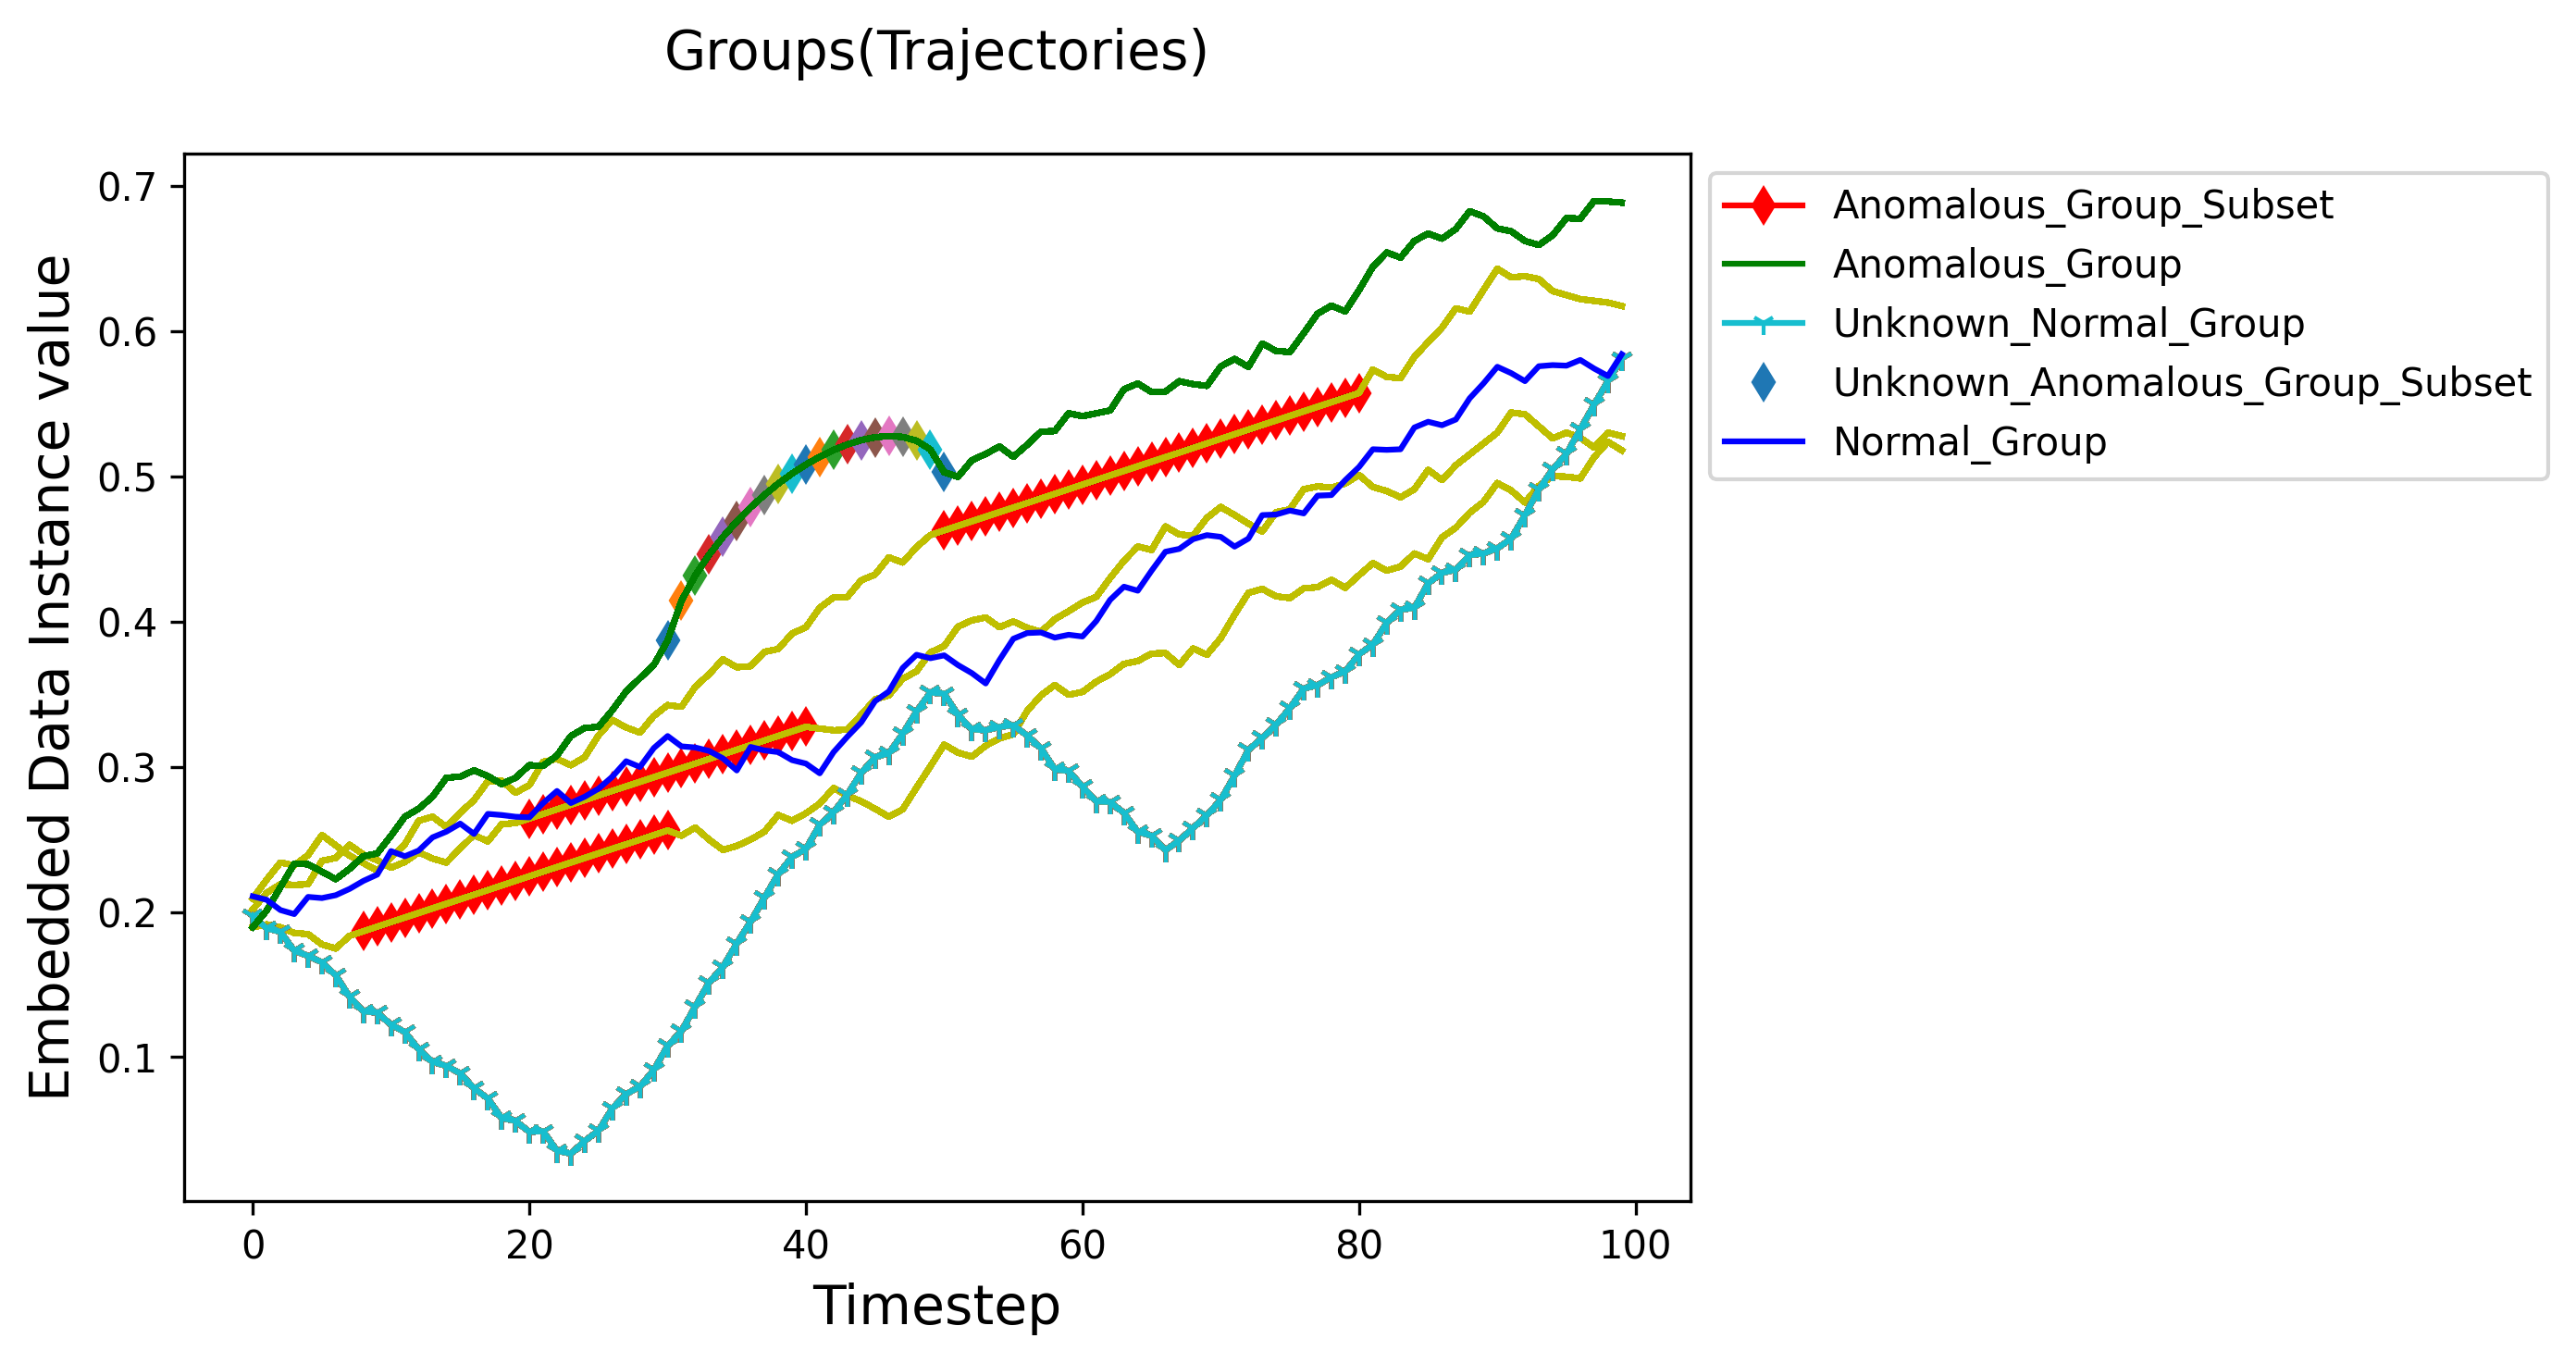

In [53]:
import pandas as pd
import numpy as np

###loading the dataset

df = pd.read_csv(filename)
###-------------------


### Embedding the Coordinates to a single value for plotting 


persons=trajectories

    
trajecs=list(range(1,persons+1))    
coords=None
for traj in trajecs:     

            df_temp=df.loc[df['Person'] == traj]
            df_temp=df_temp[['X_Coord','Y_Coord']].to_numpy()
            try:
                coords=np.vstack((coords,df_temp))
            except:
                coords=df_temp



                        
                           
mm_scaler=MinMaxScaler()#

mm_scaler.fit(coords)

coords_scaled=mm_scaler.transform(coords)

coords_scaled=torch.from_numpy(coords_scaled).float()                           
n=len(coords_scaled)-1

new_data=nn.Linear(torch.tensor(coords_scaled).shape[1],1)(torch.tensor(coords_scaled))

new_data=new_data.detach().flatten().numpy()

l=len(df.Person.unique())
m=len(df.columns)-1
n=len(df.iloc[:,-2:].to_numpy())-1
trajecs=list(range(1,persons+1))    
for traj in trajecs:     

            df_temp=df.loc[df['Person'] == traj]
            df_temp=df_temp[['Target']].to_numpy()
            try:
                labels=np.vstack((labels,df_temp))
            except:
                labels=df_temp
                
new_data=np.reshape(new_data,(l,(n+1)//l))
labels=np.reshape(labels,(l,(n+1)//l))

###-------------------


### PLotting the dataset

plt.figure(figsize=(7, 5), dpi=300)
plt.xlabel('Timestep',fontsize=14)
plt.ylabel('Embedded Data Instance value',fontsize=14)
min_point=10000
max_point=-10000
anom_trajecs=anom_trajectories
anom_trajecs2=other_anom_novelty_trajectories
anom_trajecs3=other_norm_novelty_trajectories


for traj,points in zip(df.Person.unique(),new_data):   
    
    
    if traj in anom_trajecs:
            
            
            points_list=[]
            points_modified=[]
            for i,j in list(enumerate(points)):
                
                anom_start,anom_end=traj_pair_details[traj]
                
                anom_list=list(range(anom_start,anom_end+1))
                
                if i in anom_list:
                    flag=True
                    plt.plot(i,j,'r',marker='d',label='Anomalous_Group_Subset')
                    
                    points_list.append(j)
            
            
            
            points_modified=[i for i in points if i not in points_list]
            
            if flag:
                
                for i,j in list(enumerate(points)):
                
                    plt.plot(range(len(points)),points,'y',label='Anomalous_Group')
                    flag=False
            
                
    elif traj in anom_trajecs2:
            
            
            points_list=[]
            points_modified=[]
            for i,j in list(enumerate(points)):
                
                anom_start,anom_end=traj_pair_details[traj]
                
                anom_list=list(range(anom_start,anom_end+1))
                
                if i in anom_list:
                    flag=True
                    plt.plot(i,j,'o',marker='d',label='Unknown_Anomalous_Group_Subset')
                    #print(i,j)
                    points_list.append(j)
            
            
            
            points_modified=[i for i in points if i not in points_list]
            
            if flag:
                
                for i,j in list(enumerate(points)):
                
                    plt.plot(range(len(points)),points,'g',label='Anomalous_Group')
                    flag=False
            #plt.show()               
    elif traj in anom_trajecs3:
            
            
            
            for i,j in list(enumerate(points)):
                
                    plt.plot(range(len(points)),points,marker='1',label='Unknown_Normal_Group')
                    
            #plt.show()               
            
            
    else:
        plt.plot(range(len(points)),points,color='b',label='Normal_Group')
        #plt.show()
        pass



handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1, 1))
plt.title(f'Groups(Trajectories)\n',fontsize=14)
plt.show()
###-------------------